In [ ]:
#while on coursera run this thing

from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_train[0], cmap="Greys");

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import requests

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score

for local testing $\downarrow$

In [2]:
#while working locally run this thing

mnist_data = requests.get("https://s3.amazonaws.com/img-datasets/mnist.npz") # loading from amazon may take time
with open('mnist.npz', 'wb') as f:
    f.write(mnist_data.content)
XY = np.load("mnist.npz")
(_, X_test,), (_, X_train), (_, y_train), (_, y_test) =  XY.items()

expand targets into one hot representation $\downarrow$

In [3]:
y_dummies_train = pd.get_dummies(y_train).to_dense()
y_dummies_test = pd.get_dummies(y_test).to_dense()

Architecture is: 

input $\rightarrow$ fc $\rightarrow$ relu $\rightarrow$ batchnorm $\rightarrow$ fc $\rightarrow$ relu $\rightarrow$ batchnorm $\rightarrow$ softmax

$64^2, 100$ $\rightarrow$ $100 ,50$ $\rightarrow$ $50, 10$

In [4]:
num_classes = 10

width_1 = 100
width_2 = 50

with tf.variable_scope('layer1', reuse=None):
    weights_1 = tf.get_variable('w1',(X_train.shape[1], X_train.shape[2], width_1),
                                initializer=tf.random_normal_initializer(stddev=0.1), dtype=tf.float32)
    b_1 = tf.get_variable('b1', (width_1,), initializer=tf.random_normal_initializer(stddev=0.1), dtype=tf.float32)

with tf.variable_scope('layer2', reuse=None):
    weights_2 = tf.get_variable('w2',(width_1, width_2),
                                initializer=tf.random_normal_initializer(stddev=0.2), dtype=tf.float32)
    b_2 = tf.get_variable('b2', (width_2,), initializer=tf.random_normal_initializer(stddev=0.2), dtype=tf.float32)


    
with tf.variable_scope('layer2', reuse=None):
    weights_3 = tf.get_variable('w3', (width_2, num_classes), dtype=tf.float32,
                                initializer=tf.random_normal_initializer(stddev=0.2))
    b_3 = tf.get_variable('b3', (num_classes,), dtype=tf.float32, initializer=tf.random_normal_initializer(stddev=0.2))

In [5]:
X_input = tf.placeholder(shape=(None, X_train.shape[1], X_train.shape[2]), dtype=tf.float32)
y_input = tf.placeholder(shape=(None, num_classes), dtype=tf.float32)

In [6]:
after_1_act = tf.nn.relu(tf.tensordot(X_input, weights_1, axes=[(1,2), (0,1)]) + b_1)
act_1_normed = tf.contrib.layers.batch_norm(after_1_act)
after_2_act = tf.nn.relu((tf.matmul(act_1_normed, weights_2) + b_2))
act_2_normed = tf.contrib.layers.batch_norm(after_2_act)
y_pred = tf.nn.softmax((tf.matmul(act_2_normed, weights_3) + b_3))

Usual crossentropy loss here $\downarrow$

In [7]:
loss = -tf.reduce_mean(tf.reduce_sum(y_input * tf.log(y_pred), axis=1), axis=0)

In [8]:
learning_rate = tf.placeholder(tf.float32, shape=())
optimize = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(
    loss, var_list=[weights_1, b_1, weights_2, b_2]
)

In [9]:
s = tf.InteractiveSession()
s.run(tf.global_variables_initializer())

writer = tf.summary.FileWriter("/venv/tf_venv/tf_logs/", graph=s.graph)

tf.summary.scalar('loss', loss)
merged = tf.summary.merge_all()

Generator for minibatch optimization process $\downarrow$

In [10]:
def batch_gen(X, y, iter_num=10000, batch_size=100):
    for i in range(iter_num):
        selected = np.random.randint(0, high=X.shape[0], size=batch_size)
        yield X.take(selected, axis=0), y.take(selected, axis=0)

Adaptive learning rate with decay $\downarrow$

In [11]:
num_epochs = 50
lr_decay = 0.7
lr_base = 0.2

Training part here

In [12]:
test_losses = []
losses = []

for epoch_num in range(num_epochs):
    for num, (X_batch, y_batch) in enumerate(batch_gen(X_train, y_dummies_train, iter_num=200, batch_size=1000)):
        [summary, _] = s.run([merged, optimize], 
             {
                 X_input: X_batch,
                 y_input: y_batch,
                 learning_rate: lr_base * lr_decay ** epoch_num
             })
        loss_i = s.run(loss, {X_input: X_train, y_input: y_dummies_train})
        loss_i_test = s.run(loss, {X_input: X_test, y_input: y_dummies_test})
        
        print("\rtrain/test loss at iter %i:%.4f/%.4f" % (num, loss_i, loss_i_test), end=' ')
        
        test_losses.append(loss_i_test)
        losses.append(loss_i)
        
        writer.add_summary(summary, num)
        
        
        if num % 20 == 0:
            y_predicted = s.run(y_pred, {
                 X_input: X_test,
             })
            print("acc: {}".format(accuracy_score(y_pred=np.argmax(y_predicted, axis=1), y_true=y_test)))
        

train/test loss at iter 0:1.4421/1.4109 acc: 0.5372
train/test loss at iter 20:0.3609/0.3642 acc: 0.9008
train/test loss at iter 40:0.2815/0.2854 acc: 0.9234
train/test loss at iter 60:0.2354/0.2412 acc: 0.934
train/test loss at iter 80:0.2021/0.2097 acc: 0.9442
train/test loss at iter 100:0.1774/0.1885 acc: 0.9475
train/test loss at iter 120:0.1591/0.1738 acc: 0.9523
train/test loss at iter 140:0.1466/0.1631 acc: 0.9545
train/test loss at iter 160:0.1360/0.1540 acc: 0.9561
train/test loss at iter 180:0.1260/0.1482 acc: 0.9582
train/test loss at iter 0:0.1188/0.1435 acc: 0.9612
train/test loss at iter 20:0.1089/0.1327 acc: 0.9628
train/test loss at iter 40:0.1036/0.1340 acc: 0.9622
train/test loss at iter 60:0.0995/0.1306 acc: 0.9638
train/test loss at iter 80:0.0934/0.1248 acc: 0.9663
train/test loss at iter 100:0.0917/0.1267 acc: 0.9645
train/test loss at iter 120:0.0867/0.1219 acc: 0.9667
train/test loss at iter 140:0.0841/0.1197 acc: 0.966
train/test loss at iter 160:0.0820/0.1221 

KeyboardInterrupt: 

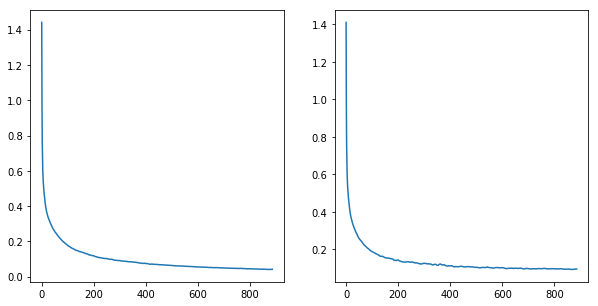

In [16]:
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axs[0].plot(range(len(losses)), losses)
axs[1].plot(range(len(test_losses)), test_losses)

In [18]:
y_predicted = s.run(y_pred, {
                 X_input: X_test,
             })
print("accuracy: {}".format(accuracy_score(y_pred=np.argmax(y_predicted, axis=1), y_true=y_test)))

accuracy: 0.9741


### Final accuracy is 97.4 %

4


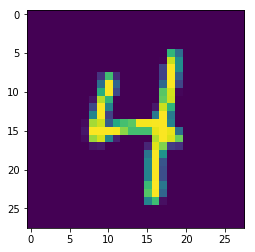

In [28]:
n=19
print(np.argmax(y_predicted, axis=1)[n])
plt.imshow(X_test[n])